In [87]:
import pandas as pd
import numpy as np 

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from sklearn import tree

In [88]:
path = "./"
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA.csv")

In [89]:
#Set to True if using charge_throughput as response variable, False if using cycle life (X.capacity_0.8)
ct = True

#True if training on old data and testing on new data, false if mixing both old and new data into train and test set
#Only applies to when old and new data are combined
train_old_test_new = False

#True if including 'X.integrated_time_temperature_cycles_1:100' to full model, False if not
integrated_time_temp_cycles = False

#True if applying a log transformtion to combined data, False if no transformation
log_transformation = True

#True if including internal resistance for old data, false if not (no internal resistance variable for new data)
ir = False

#True if standardizing explanatory variables, false otherwise (necessary for elastic net)
standardized = True

# Old Data

In [90]:
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [91]:
variance_model_features = 'X.abs_variance_discharge_capacity_difference_cycles_2:100'
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference'
                            ]
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5']

if integrated_time_temp_cycles:
    full_model_features.append('X.integrated_time_temperature_cycles_1:100')

if ir:
    full_model_features.append('X.min_internal_resistance_cycles_2:100')
    full_model_features.append('X.internal_resistance_difference_cycles_2:100')

if ct:
    y = 'charge_throughput'
else:
    y = 'cycle_index'

In [92]:
if standardized:
    
    all_model_features = full_model_features + list(set(discharge_model_features)-set(full_model_features))

    def standardize(data_subset):
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data_subset)
        scaled_df = pd.DataFrame(scaled_data, index=data_subset.index, columns=data_subset.columns)
        return scaled_df

    old_ct[all_model_features] = standardize(old_ct[all_model_features])   

In [93]:
train_ind = list(range(0,old_ct.shape[0],2))
test_ind = list(range(1,old_ct.shape[0],2))

# train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
#         35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
#         69, 71, 73, 75, 77, 79, 81]
# test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
#         34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
#         68, 70, 72, 74, 76, 78, 80, 82, 83]

## Variance model features

In [94]:
X_train_var = old_ct.iloc[train_ind][[variance_model_features]]
y_train = old_ct.iloc[train_ind][[y]]

X_test_var = old_ct.iloc[test_ind][[variance_model_features]]
y_test = old_ct.iloc[test_ind][[y]]

In [95]:
reg_var = RandomForestRegressor().fit(X_train_var, np.ravel(y_train))

y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

print("Random Forest with variance model feature")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Random Forest with variance model feature
Training RMSE:  74.1731063421605
Test RMSE:  231.30918569630145
Mean % Train Error:  0.05820674508473702
Mean % Test Error:  0.21109738874958825


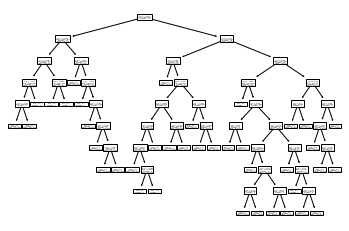

In [96]:
tree.plot_tree(reg_var.estimators_[0])
plt.show()

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

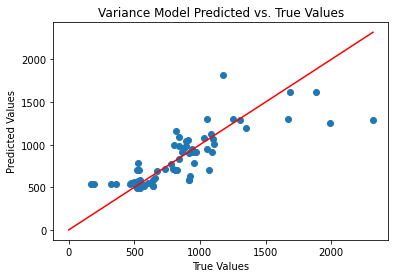

In [97]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

## Discharge Model Features

In [98]:
# discharge model
X_train_dis = old_ct.iloc[train_ind][discharge_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_dis = old_ct.iloc[test_ind][discharge_model_features]
y_test = old_ct.iloc[test_ind][[y]]

reg_dis = RandomForestRegressor().fit(X_train_dis,np.ravel(y_train))
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

print("Random forest with discharge model features")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
print("Mean % Train Error: ", mape_train_dis)
print("Mean % Test Error: ", mape_test_dis)

Random forest with discharge model features
Training RMSE:  78.87556901501698
Test RMSE:  206.8992796644478
Mean % Train Error:  0.04921122533584599
Mean % Test Error:  0.20400686099600546


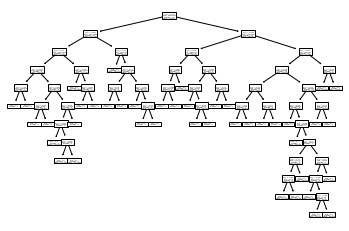

In [99]:
# sample decision tree
tree.plot_tree(reg_dis.estimators_[0])
plt.show()

In [100]:
reg_dis.feature_importances_

array([0.56764879, 0.18159546, 0.0509029 , 0.02903689, 0.03004988,
       0.14076608])

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN)')

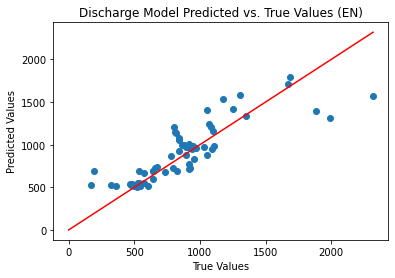

In [101]:
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN)")

## Full model features

In [105]:
# full model
X_train_full = old_ct.iloc[train_ind][full_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_full = old_ct.iloc[test_ind][full_model_features]
y_test = old_ct.iloc[test_ind][[y]]

reg_full = RandomForestRegressor().fit(X_train_full,np.ravel(y_train))

y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

print("Random Forest with Full model features")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Random Forest with Full model features
Training RMSE:  73.51473456701204
Test RMSE:  207.54951711847443
Mean % Train Error:  0.051009676911412276
Mean % Test Error:  0.1993870859520411


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

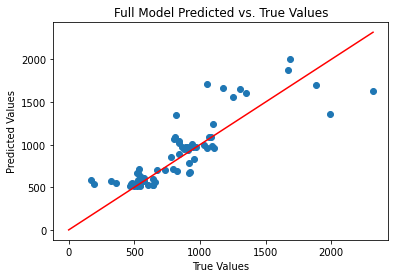

In [103]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

# New Data

In [107]:
new_df = pd.read_csv(path + "NewData/LFPBatteries.csv")

new_ct["battery_index"] = new_ct["battery"].str[-2:].astype('int')

new_ct_full = new_df.merge(how = 'inner',right = new_ct, left_index = True, right_on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [108]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]

In [109]:
if standardized:
    new_ct_full[all_model_features] = standardize(
        new_ct_full[all_model_features].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    )

In [110]:
# Variance model
X_train_var = new_ct_full.iloc[train_ind][[variance_model_features]]
X_train_var.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_var.index][[y]]

X_test_var = new_ct_full.iloc[test_ind][[variance_model_features]]
X_test_var.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_var.index][[y]]

In [ ]:
reg_var = RandomForestRegressor().fit(X_train_var, np.ravel(y_train))
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)